## 数据集处理
通过特征衍生生成五个新特征：每死总输出，每死对敌方英雄输出，每死承受伤害，击杀数减去死亡数，击杀数减去死亡数加上一半助攻数
从训练集分离出1w数据用于本地测试（170000-179999）
由于不了解如何通过python修改excel，上述衍生和分离操作均在excel上完成

In [1]:
import pandas as pd
import paddle
import numpy as np
%pylab inline
import seaborn as sns
from sklearn.metrics import accuracy_score


train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')
evaluation_df = pd.read_csv('dataset/evaluation.csv')

train_df = train_df.drop(['id', 'timecc'], axis=1)
test_df = test_df.drop(['id', 'timecc'], axis=1)
evaluation_df = evaluation_df.drop(['id', 'timecc'], axis=1)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


Populating the interactive namespace from numpy and matplotlib


## 数据分析
无改动

In [2]:
train_df.isnull().mean(0)

win                       0.0
kills                     0.0
deaths                    0.0
assists                   0.0
largestkillingspree       0.0
largestmultikill          0.0
longesttimespentliving    0.0
doublekills               0.0
triplekills               0.0
quadrakills               0.0
pentakills                0.0
totdmgdealt               0.0
magicdmgdealt             0.0
physicaldmgdealt          0.0
truedmgdealt              0.0
largestcrit               0.0
totdmgtochamp             0.0
magicdmgtochamp           0.0
physdmgtochamp            0.0
truedmgtochamp            0.0
totheal                   0.0
totunitshealed            0.0
dmgtoturrets              0.0
totdmgtaken               0.0
magicdmgtaken             0.0
physdmgtaken              0.0
truedmgtaken              0.0
wardsplaced               0.0
wardskilled               0.0
firstblood                0.0
totdmgtochampdeath        0.0
totdmgtakendeath          0.0
totdmgtochamp.1           0.0
killsdeath

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


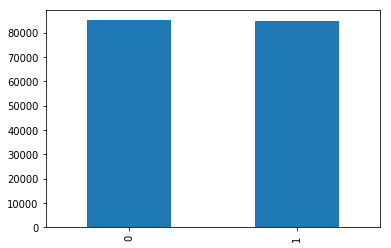

In [3]:
train_df['win'].value_counts().plot(kind='bar')

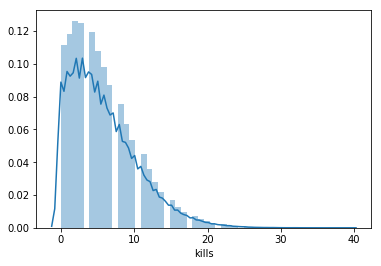

In [4]:
sns.distplot(train_df['kills'])

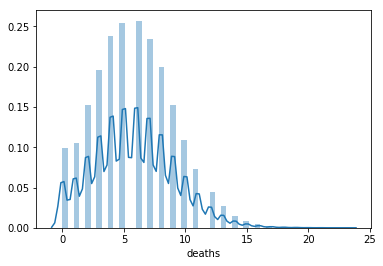

In [5]:
sns.distplot(train_df['deaths'])

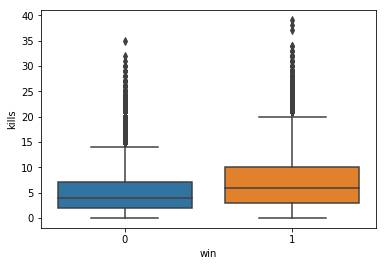

In [6]:
sns.boxplot(y='kills', x='win', data=train_df)

Text(0,0.5,'deaths')

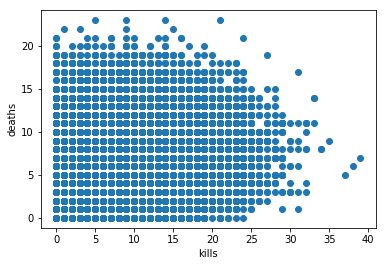

In [7]:
plt.scatter(train_df['kills'], train_df['deaths'])
plt.xlabel('kills')
plt.ylabel('deaths')

In [8]:
for col in train_df.columns[1:]:
    train_df[col] /= train_df[col].max()
    test_df[col] /= test_df[col].max()
    evaluation_df[col] /= evaluation_df[col].max()

## 搭建模型
本想通过增加全连接层来提升模型，但测试多次没有太大作用，所以保持原模型，仅将第一层输入更改

In [9]:
class Classifier(paddle.nn.Layer):
    # self代表类的实例自身
    def __init__(self):
        # 初始化父类中的一些参数
        super(Classifier, self).__init__()
        
        self.fc1 = paddle.nn.Linear(in_features=34, out_features=40)
        # self.fc2 = paddle.nn.Linear(in_features=40, out_features=100)
        # self.fc3 = paddle.nn.Linear(in_features=100, out_features=200)
        # self.fc4 = paddle.nn.Linear(in_features=200, out_features=400)
        # self.fc5 = paddle.nn.Linear(in_features=400, out_features=1000)
        # self.fc6 = paddle.nn.Linear(in_features=1000, out_features=500)
        # self.fc7 = paddle.nn.Linear(in_features=500, out_features=200)
        # self.fc8 = paddle.nn.Linear(in_features=200, out_features=100)
        # self.fc9 = paddle.nn.Linear(in_features=100, out_features=40)
        self.fc10 = paddle.nn.Linear(in_features=40, out_features=1)
        self.relu = paddle.nn.ReLU()
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.relu(self.fc1(inputs))
        x = self.fc10(x)
        return x

In [10]:
model = Classifier()
model.train()
opt = paddle.optimizer.SGD(learning_rate=0.01, parameters=model.parameters())
loss_fn = paddle.nn.BCEWithLogitsLoss()

## 模型训练
迭代次数设置300，其余不变

In [11]:
EPOCH_NUM = 300   # 设置外层循环次数
BATCH_SIZE = 100  # 设置batch大小
training_data = train_df.iloc[:-1000,].values.astype(np.float32)
val_data = train_df.iloc[-1000:, ].values.astype(np.float32)

# 定义外层循环
for epoch_id in range(EPOCH_NUM):
    # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
    
    np.random.shuffle(training_data)
    
    # 将训练数据进行拆分，每个batch包含10条数据
    mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
    
    # 定义内层循环
    for iter_id, mini_batch in enumerate(mini_batches):
        x = np.array(mini_batch[:, 1:]) # 获得当前批次训练数据
        y = np.array(mini_batch[:, :1]) # 获得当前批次训练标签
        
        # 将numpy数据转为飞桨动态图tensor的格式
        features = paddle.to_tensor(x)
        y = paddle.to_tensor(y)
        
        # 前向计算
        predicts = model(features)
        
        # 计算损失
        loss = loss_fn(predicts, y, )
        avg_loss = paddle.mean(loss)
        if iter_id%200==0:
            acc = (predicts > 0).astype(int).flatten() == y.flatten().astype(int)
            acc = acc.astype(float).mean()

            print("epoch: {}, iter: {}, loss is: {}, acc is {}".format(epoch_id, iter_id, avg_loss.numpy(), acc.numpy()))
        
        # 反向传播，计算每层参数的梯度值
        avg_loss.backward()
        # 更新参数，根据设置好的学习率迭代一步
        opt.step()
        # 清空梯度变量，以备下一轮计算
        opt.clear_grad()

In [12]:
model.eval()
test_data = paddle.to_tensor(test_df.values.astype(np.float32))
test_predict = model(test_data)
test_predict = (test_predict > 0).astype(int).flatten()

## 模型本地测试
使用evaluation.csv在本地测试模型准确率

In [13]:
evaluation_data = paddle.to_tensor(evaluation_df.iloc[:, 1:].values.astype(np.float32))
evaluation_predict = model(evaluation_data)
evaluation_predict = (evaluation_predict > 0).astype(int).flatten()
evaluation_true = evaluation_df.iloc[:, :1].values.astype(int).flatten()
accuracy_score(evaluation_true, evaluation_predict)

0.8252

In [14]:
pd.DataFrame({'win':
              test_predict.numpy()
             }).to_csv('submission.csv', index=None)

!zip submission.zip submission.csv

updating: submission.csv (deflated 90%)
